In [235]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import numpy as np
import pandas as pd
import datetime
from scipy import stats
from scipy.stats import gaussian_kde, norm

from scipy.stats import t
from scipy.stats import linregress
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy.stats import multinomial

from arch import arch_model
import torch
from numba import cuda
import numba as numba
import statsmodels.formula.api as smf


start = datetime.datetime(1980,1,1)
end = datetime.datetime(2018,12,31)
#end = datetime.date.today()


from pandas_datareader import data as wb  

ticker = '^GSPC' 
df = pd.DataFrame()

df[ticker] = wb.DataReader(ticker, data_source='yahoo', start=start, end=end)['Close']
log_returns = np.log(1 + df.pct_change()).dropna()



def entropy(hist, bit_instead_of_nat=False):

    h = np.asarray(hist, dtype=np.float64)

    h = h/h.sum()
    log_fn = np.ma.log2 if bit_instead_of_nat else np.ma.log
    return -(h*log_fn(h)).sum()

# w=window length (trading days)
#alpha = the significance level
w=1000
alpha=0.01
w_backtesting=1000
Tail_Entropy=[]
TE_ES=[]
ES=[]
ES_Gaussian=[]
VaR_empiric=[]
VaR_normal=[]
VaR_GARCH_n=[]
ES_GARCH_n=[]
VaR_GARCH_t=[]
ES_GARCH_t=[]

VaR_t=[]
ES_t=[]
B0=[]
B1=[]
P=[]
#from numba import autojit
#@autojit
def Rolling_ES(log_returns,w,alpha):
    iterations=len(log_returns)-w

    for i in range(1,iterations):
        ret=log_returns[i:(w+i-1)]
        q=ret.quantile(alpha)
   
        x=(ret[ret<=q]).dropna()
        y=np.asarray(x)
        n=len(y)
        es=-np.mean(y)
        ES.append(es)
   
        bins=5
        hist=np.histogram(y, bins)

        p=hist[0].astype(float)/hist[0].sum()     #probability of bins
        bootstrap_ent=[]
        for k in range(1,1000):
            rv=multinomial.rvs(100, p, size=1, random_state=None)
            b_ent=entropy(rv, bit_instead_of_nat=True)/np.log2(bins)
            bootstrap_ent.append(b_ent)
                
        b0=np.min(hist[1])
        b1=np.max(hist[1])
        B0.append(b0)
        B1.append(b1)
        P.append(p)
        
        ent=2*(entropy(hist[0], bit_instead_of_nat=True)/np.log2(bins))-np.mean(bootstrap_ent)
        #ent=entropy(hist[0], bit_instead_of_nat=True)/np.log2(bins)
        te=-(b0+(b1-b0)*ent/2)
        
        Tail_Entropy.append(ent)
        TE_ES.append(te)

        mu=ret.mean()
        sigma=ret.std()
        v_normal=norm.ppf(alpha, mu, sigma);
        es_n = sigma * norm.pdf(norm.ppf(alpha)) / alpha
        ES_Gaussian.append(es_n);
        VaR_normal.append(v_normal);
        
        r = t.fit(ret)
        
        nu = r[0]
        xanu = t.ppf(alpha, nu)
        
        v_t = -(np.sqrt((nu-2)/nu) * t.ppf(1-alpha, nu)*sigma - mu)

        es_t = (-1/alpha * (1-nu)**(-1) * (nu-2+xanu**2) * t.pdf(xanu, nu)*sigma  - mu)
        ES_t.append(es_t);
        VaR_t.append(v_t);
        
        v_empiric=ret.quantile(alpha);
        VaR_empiric.append(v_empiric);

        # define model with Normal residuals
        model = arch_model(ret*100, vol='GARCH', p=1, q=1);
        # fit model
        model_fit = model.fit(disp=0);
        # forecast the test set
        yhat = model_fit.forecast(horizon=1);
        var_n=np.sqrt(yhat.variance.values[-1])/100 * norm.ppf(alpha) +mu
        VaR_GARCH_n.append(var_n);
      
        es_g_n= (alpha**-1 * norm.pdf(norm.ppf(alpha))*np.sqrt(yhat.variance.values[-1])/100 - mu)
        ES_GARCH_n.append(es_g_n);
        
        # define model
        model = arch_model(ret*100, vol='GARCH', p=1, q=1,dist='StudentsT');
        # fit model
        model_fit = model.fit(disp=0);
        df=(model_fit.params[4]);
        # forecast the test set
        yhat = model_fit.forecast(horizon=1);
        var_t=np.sqrt(yhat.variance.values[-1])/100 * t.ppf(alpha,df) +mu;
        VaR_GARCH_t.append(var_t);
        xanu = t.ppf(alpha, df)
        es_g_t = (-1/alpha * (1-df)**(-1) * (nu-2+xanu**2) * 
                  t.pdf(xanu,df)*np.sqrt(yhat.variance.values[-1])/100 - mu)
        ES_GARCH_t.append(es_g_t);


In [236]:
%%capture
from timeit import default_timer as timer
start = timer()
Rolling_ES(log_returns,w,alpha)
dt = timer() - start

print ("Created in %f s" % dt)



In [237]:
print ("Created in %f s" % dt)


Created in 1756.251923 s


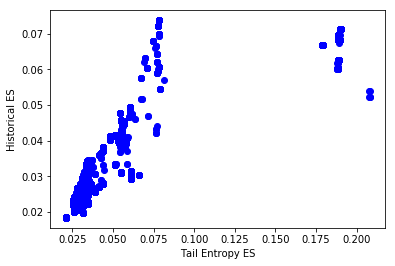

                            OLS Regression Results                            
Dep. Variable:                     ES   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     2231.
Date:                Mon, 26 Aug 2019   Prob (F-statistic):               0.00
Time:                        10:08:49   Log-Likelihood:                 24157.
No. Observations:                8833   AIC:                        -4.831e+04
Df Residuals:                    8831   BIC:                        -4.830e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0272      0.000     81.060      0.0

In [238]:
plt.plot(TE_ES,ES, 'o',c='blue')
plt.ylabel( 'Historical ES' )
plt.xlabel( 'Tail Entropy ES' )
#plt.legend(loc='upper center',bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True)
plt.show()

Tail_Entropy=pd.DataFrame(Tail_Entropy)
ES_GARCH_t=pd.DataFrame( ES_GARCH_t)
data=pd.concat([Tail_Entropy,  ES_GARCH_t], axis=1)
lm = smf.ols(formula = "ES~ ES_GARCH_t", data=data).fit()
print (lm.summary())

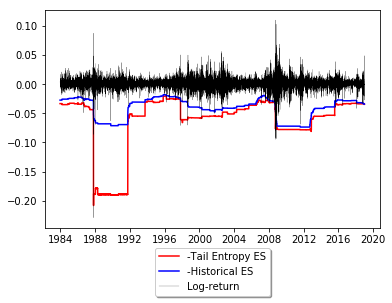

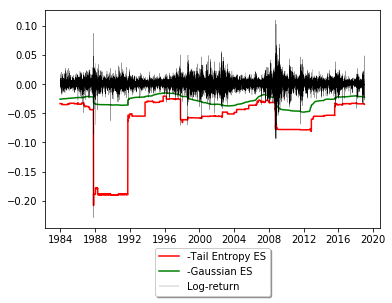

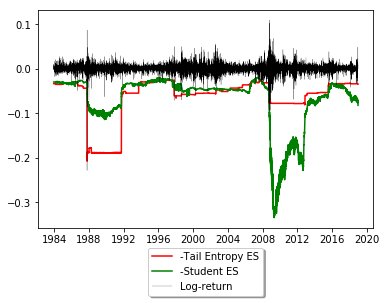

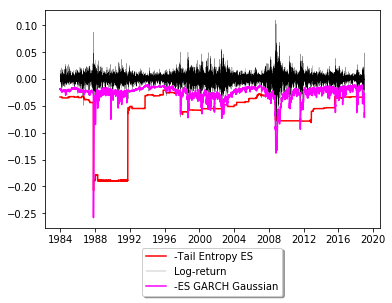

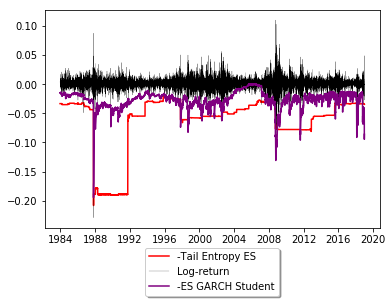

In [239]:
df_new=df[(w+2):len(df)]
dates=df_new.index.tolist()

TE_ES=-np.asarray(TE_ES)
ES_Gaussian=-np.asarray(ES_Gaussian, dtype=np.float32)
ES=-np.asarray(ES)
VaR_empiric=np.asarray(VaR_empiric)

VaR_GARCH_n=np.asarray(VaR_GARCH_n)
ES_GARCH_n=-np.asarray(ES_GARCH_n)

VaR_GARCH_t=np.asarray(VaR_GARCH_t)
ES_GARCH_t=-np.asarray(ES_GARCH_t)

VaR_t=np.asarray(VaR_t)
ES_t=-np.asarray(ES_t)

returns=np.asarray(log_returns[(w+1):len(log_returns)])

#fig, ax = plt.subplots(figsize=(15, 9))
plt.plot(dates,TE_ES, label='-Tail Entropy ES',c='red')
plt.plot(dates, ES, label='-Historical ES',c='blue')

plt.plot(dates, returns, label='Log-return',c='black',linewidth=0.2)
#plt.plot(VaR_empiric, label='VaR')
#plt.plot(VaR_GARCH_n, label='VaR GARCH Gaussian')

plt.legend(loc='upper center',bbox_to_anchor=(0.5, -0.07), fancybox=True, shadow=True)
plt.show()

#fig, ax = plt.subplots(figsize=(15, 9))
plt.plot(dates,TE_ES, label='-Tail Entropy ES',c='red')

plt.plot(dates,ES_Gaussian, label='-Gaussian ES', c='green')
plt.plot(dates,returns, label='Log-return',c='black',linewidth=0.2)
plt.legend(loc='upper center',bbox_to_anchor=(0.5, -0.07), fancybox=True, shadow=True)
plt.show()

#fig, ax = plt.subplots(figsize=(15, 9))
plt.plot(dates,TE_ES, label='-Tail Entropy ES',c='red')

plt.plot(dates,ES_t, label='-Student ES', c='green')
plt.plot(dates,returns, label='Log-return',c='black',linewidth=0.2)
plt.legend(loc='upper center',bbox_to_anchor=(0.5, -0.07), fancybox=True, shadow=True)
plt.show()


#fig, ax = plt.subplots(figsize=(15, 9))
plt.plot(dates,TE_ES, label='-Tail Entropy ES',c='red')
plt.plot(dates,returns, label='Log-return',c='black',linewidth=0.2)
#plt.plot(VaR_empiric, label='VaR')
#plt.plot(VaR_GARCH_n, label='VaR GARCH Gaussian')
plt.plot(dates,ES_GARCH_n, label='-ES GARCH Gaussian' ,c='magenta')

plt.legend(loc='upper center',bbox_to_anchor=(0.5, -0.07), fancybox=True, shadow=True)
plt.show()

#fig, ax = plt.subplots(figsize=(15, 9))
plt.plot(dates,TE_ES, label='-Tail Entropy ES',c='red')

plt.plot(dates,returns, label='Log-return',c='black',linewidth=0.2)

plt.plot(dates,ES_GARCH_t, label='-ES GARCH Student',c='purple')
plt.legend(loc='upper center',bbox_to_anchor=(0.5, -0.07), fancybox=True, shadow=True)
plt.show()


In [240]:
def z2(es,var,alpha,w_backtesting):
    returns=np.asarray(log_returns[(w+1):len(log_returns)])
    itr=len(returns)-w_backtesting-1
    ret_total=returns[1:(itr+w_backtesting)]
    var_total=var[1:(itr+w_backtesting)]
    es_total=es[1:(itr+w_backtesting)]
    x=-np.abs(var_total)
    res=(ret_total<x)
    z=(res*ret_total)/(np.abs(es_total)*alpha)
    Z2_total=np.nanmean(z)+1
    Z2=[]
    Z_2=[]
    
    for i in range(1,itr):
        ret=returns[i:(i+w_backtesting)]
        vart=var[i:(i+w_backtesting)]
        est=es[i:(i+w_backtesting)]
        x=-np.abs(vart)
        res=(ret<x)
        zt=(res*ret)/(np.abs(est)*alpha)
        z2=np.nanmean(zt)+1
        z=(z2<-0.7)
        Z2.append(z2)
        Z_2.append(z)
    EZ2=np.mean(Z_2)
 
    return EZ2, Z2_total, Z2

In [241]:
dates_backtesting=[]
returns=np.asarray(log_returns[(w+1):len(log_returns)])
itr=len(returns)-w_backtesting-1
for i in range(1,itr):
    date=dates[i+w_backtesting]
    dates_backtesting.append(date)



In [242]:

EZ2=[]

Z2_total=[]
ez2, z2_total,Z2_ES=z2(ES, VaR_empiric,alpha,w_backtesting)


EZ2.append(ez2)

Z2_total.append(z2_total)


ez2, z2_total,Z2_TE_ES=z2(TE_ES, VaR_empiric,alpha,w_backtesting)
EZ2.append(ez2)

Z2_total.append(z2_total)

ez2, z2_total,Z2_ES_GARCH_n=z2(ES_GARCH_n, VaR_GARCH_n, alpha,w_backtesting)
EZ2.append(ez2)

Z2_total.append(z2_total)

ez2,z2_total,Z2_ES_GARCH_t=z2(ES_GARCH_t, VaR_GARCH_t, alpha,w_backtesting)
EZ2.append(ez2)

Z2_total.append(z2_total)

ez2,z2_total,Z2_ES_Gaussian=z2(ES_Gaussian, VaR_normal, alpha,w_backtesting)
EZ2.append(ez2)

Z2_total.append(z2_total)

ez2,z2_total,Z2_ES_t=z2(ES_t, VaR_t, alpha,w_backtesting)
EZ2.append(ez2)

Z2_total.append(z2_total)

df = pd.DataFrame(EZ2,index = ['Historical ES','TE_ES', 'ES_GARCH_n', 'ES_GARCH_t','ES_Gaussian', 'ES_t'])
df.columns=['Percentage of failures Z2']
df



C:\Users\dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
C:\Users\dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less


,Percentage of failures Z2
Historical ES,0.398161
TE_ES,0.282850
ES_GARCH_n,0.770272
ES_GARCH_t,0.267271
ES_Gaussian,0.555485
ES_t,0.380411


In [243]:
df1 = pd.DataFrame(Z2_total,index = ['Historical ES','TE_ES', 'ES_GARCH_n', 'ES_GARCH_t','ES_Gaussian', 'ES_t'])
df1.columns=['Z2-whole period']
df1

,Z2-whole period
Historical ES,-0.624020
TE_ES,-0.229403
ES_GARCH_n,-1.385109
ES_GARCH_t,-2.781373
ES_Gaussian,-1.877009
ES_t,-0.328385


In [249]:
dates_backtesting=pd.DataFrame(dates_backtesting)
Z2_ES=pd.DataFrame(Z2_ES)
Z2_TE_ES=pd.DataFrame(Z2_TE_ES)
Z2_ES_GARCH_n=pd.DataFrame(Z2_ES_GARCH_n)
Z2_ES_GARCH_t=pd.DataFrame(Z2_ES_GARCH_t)
Z2_ES_Gaussian=pd.DataFrame(Z2_ES_Gaussian)
Z2_ES_t=pd.DataFrame(Z2_ES_t)
Z2=pd.concat([dates_backtesting, Z2_ES,Z2_TE_ES, Z2_ES_GARCH_n,Z2_ES_GARCH_t, Z2_ES_Gaussian, Z2_ES_t], axis=1)
Z2.columns=['Date','Historical ES','Tail Entropy ES', 'n-GARCH(1,1) ES', 't-GARCH(1,1) ES','Gaussian ES', 'Students t ES']
Z2.set_index('Date', inplace=True)


Z2.idxmin(axis=0, skipna=True)

Historical ES     2009-01-21
Tail Entropy ES   2009-01-21
n-GARCH(1,1) ES   2010-05-07
t-GARCH(1,1) ES   2008-09-30
Gaussian ES       2010-06-04
Students t ES     2010-10-11
dtype: datetime64[ns]

In [245]:
Z2.min()

Historical ES    -4.824460
TE_ES            -3.934827
ES_GARCH_n       -2.950670
ES_GARCH_t      -25.363958
ES_Gaussian      -7.552263
ES_t             -2.716929
dtype: float64

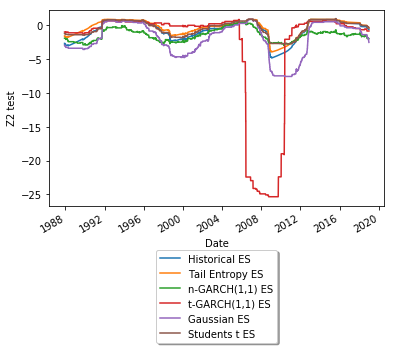

In [250]:
Z2.plot()
plt.ylabel('Z2 test')
plt.legend(loc='upper center',bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True)
plt.show()

In [247]:
TE_ES=pd.DataFrame(TE_ES)
returns=pd.DataFrame(returns)
ES=pd.DataFrame(ES)
ES_n=pd.DataFrame(ES_Gaussian)
ES_t=pd.DataFrame(ES_t)
ES_GARCH_t=pd.DataFrame(ES_GARCH_t)
ES_GARCH_n=pd.DataFrame(ES_GARCH_n)

VaR_empiric=pd.DataFrame(VaR_empiric)
VaR_GARCH_n=pd.DataFrame(VaR_GARCH_n)
VaR_GARCH_t=pd.DataFrame(VaR_GARCH_t)
VaR_GARCH_n=pd.DataFrame(VaR_GARCH_n)
VaR_normal=pd.DataFrame(VaR_normal)
VaR_t=pd.DataFrame(VaR_t)
Entropy=pd.DataFrame(Tail_Entropy)
date=pd.DataFrame(dates)
results=pd.concat([date, returns, ES, TE_ES, ES_n, ES_t, ES_GARCH_n, ES_GARCH_t,
                  VaR_empiric,VaR_GARCH_n, VaR_GARCH_t, VaR_normal,VaR_t, Entropy ], axis=1)
results.columns=['date','Return','ES', 'TE_ES', 'ES_n', 'ES_T', 'ES_GARCH_n', 'ES_GARCH_t',
                'VaR_Empiric','VaR_GARCH_n', 'VaR_GARCH_t', 'VaR_normal','VaR_t', 'Entropy']


results.to_excel(r'D:\PROIECTE\Modelling Expected Shortfall with Tail Entropy\ES_1.xlsx')
#res

In [248]:
B0=pd.DataFrame(B0)
B1=pd.DataFrame(B1)
P=pd.DataFrame(P)

tail=pd.concat([B0, B1, P], axis=1)
tail.columns=['b0','b1', 'p1','p2','p3','p4','p5']#,'p6','p7','p8','p9','p10' ]
#tail.to_excel(r'D:\PROIECTE\Modelling Expected Shortfall with Tail Entropy\tail_1.xlsx')